In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import re
import string
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
raw_dataset = pd.read_csv("/kaggle/input/amazon-reviews-dataset/cleaned_reviews.csv")
raw_dataset.drop(columns=['cleaned_review_length', 'review_score'], inplace=True)
raw_dataset.head()

,sentiments,cleaned_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and lags find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...


# Preprocessing raw dataset

In [ ]:
raw_dataset['labels'] = [class_names.index(sentiment) for sentiment in list(sentiments)]

In [ ]:
raw_dataset.head()

,sentiments,cleaned_review,labels
0,positive,i wish would have gotten one earlier love it a...,0
1,neutral,i ve learned this lesson again open the packag...,1
2,neutral,it is so slow and lags find better option,1
3,neutral,roller ball stopped working within months of m...,1
4,neutral,i like the color and size but it few days out ...,1


In [ ]:
dataset = raw_dataset.drop(columns=['sentiments'])
dataset.head()

,cleaned_review,labels
0,i wish would have gotten one earlier love it a...,0
1,i ve learned this lesson again open the packag...,1
2,it is so slow and lags find better option,1
3,roller ball stopped working within months of m...,1
4,i like the color and size but it few days out ...,1


In [ ]:
dataset.shape

(17340, 2)

In [ ]:
train, val, test = np.split(dataset.sample(frac=1), [int(0.8 * len(dataset)), int(0.9 * len(dataset))])

In [ ]:
train.head()

,cleaned_review,labels
5138,the perfect cute little mouse update had this ...,0
69,received product on the th charged it and star...,0
9064,i don game so did not find it fair to give it ...,0
3908,the rose gold color is very pretty and the col...,1
16337,just what was looking for to use at work great...,0


In [ ]:
val.head()

,cleaned_review,labels
16665,the only reason gave it stars is jbl for some ...,1
6359,like this new mouse it works well and installa...,0
141,perfect little mouse this mouse is so easy to ...,0
4423,the mouse wheel broke and just spins now used ...,1
17164,best portable speaker ve owned out of purposel...,0


In [ ]:
test.head()

,cleaned_review,labels
16923,great product excellent sound,0
5645,there was no usb adapter included so it essent...,2
2818,i loved the changing colors and the ease of us...,0
12645,sound is ok lights are cool mic isn very good ...,0
1850,works great was gift for my mom she loves it,0


# Convert Dataset

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    text = list(dataframe['cleaned_review'])
    labels = list(dataframe['labels'])
    ds = tf.data.Dataset.from_tensor_slices((np.array(text), np.array(labels)))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size).prefetch(batch_size)
    return ds
    

In [ ]:
raw_train_ds = df_to_dataset(train)
raw_val_ds = df_to_dataset(val)
raw_test_ds = df_to_dataset(test)

In [ ]:
[(train_texts, train_labels)] = raw_train_ds.take(1)

In [ ]:
print(train_texts[0].numpy())
print("="*100)
print(class_names[train_labels[0].numpy()])

b'good sound'
neutral


# Vectorize Text

In [ ]:
def standardization(input_text):
    text = tf.strings.lower(input_text)
    text = tf.strings.regex_replace(text, '[%s]' % re.escape(string.punctuation), '')
    return text

In [ ]:
vocab_size = 10000
sequence_length = 50
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [ ]:
train_texts = train_ds.map(lambda text, label: text)
vectorize_layer.adapt(train_texts)

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))
first_text, first_label = text_batch[0], label_batch[0]
print("Review", first_text)
print("="*120)
print("Label", first_label)
print("="*120)
print("Vectorized review\n", vectorize_layer(first_text))

Review tf.Tensor(b'it is little bit but the sound makes up for it', shape=(), dtype=string)
Label tf.Tensor(1, shape=(), dtype=int64)
Vectorized review
 tf.Tensor(
[  3   7 121 240  13   2  26 292  46   6   3   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int64)


In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names))
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_4 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 160,067
Trainable params: 160,067
Non-trainable params: 0
________________________________________________

In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50
434/434 [==============================] - 3s 5ms/step - loss: 0.9171 - accuracy: 0.5499 - val_loss: 0.8434 - val_accuracy: 0.5784
Epoch 2/50
434/434 [==============================] - 2s 4ms/step - loss: 0.8032 - accuracy: 0.6314 - val_loss: 0.7501 - val_accuracy: 0.7042
Epoch 3/50
434/434 [==============================] - 2s 4ms/step - loss: 0.7193 - accuracy: 0.7045 - val_loss: 0.6706 - val_accuracy: 0.7561
Epoch 4/50
434/434 [==============================] - 2s 4ms/step - loss: 0.6540 - accuracy: 0.7406 - val_loss: 0.6165 - val_accuracy: 0.7832
Epoch 5/50
434/434 [==============================] - 2s 4ms/step - loss: 0.6065 - accuracy: 0.7662 - val_loss: 0.5786 - val_accuracy: 0.7953
Epoch 6/50
434/434 [==============================] - 2s 4ms/step - loss: 0.5696 - accuracy: 0.7847 - val_loss: 0.5490 - val_accuracy: 0.8010
Epoch 7/50
434/434 [==============================] - 2s 4ms/step - loss: 0.5354 - accuracy: 0.7982 - val_loss: 0.5247 - val_accuracy: 0.8097
Epoch 

# Visualize training result

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.917103,0.549885,0.843361,0.578431
1,0.803201,0.631416,0.750086,0.704152
2,0.719253,0.704513,0.670610,0.756055
3,0.653969,0.740629,0.616548,0.783160
4,0.606465,0.766220,0.578610,0.795271


<AxesSubplot:>

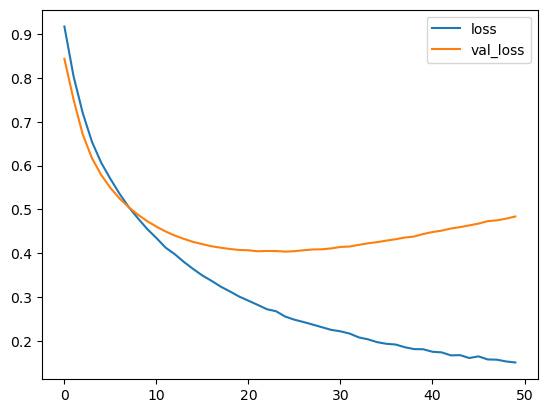

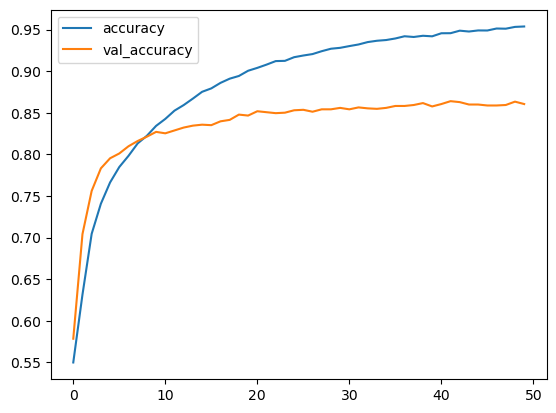

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

# Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

55/55 [==============================] - 0s 2ms/step - loss: 0.4961 - accuracy: 0.8743
Loss:  0.4960750341415405
Accuracy:  0.8742791414260864


# Predict New Data

In [ ]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    tf.keras.layers.Activation("softmax")
])
model.summary()
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_4 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 160,067
Trainable params: 160,067
Non-trainable params: 0
________________________________________________

In [ ]:
test_text = raw_test_ds.map(lambda text, label: text)
test_label = export_model.predict(test_text)

55/55 [==============================] - 0s 2ms/step


In [ ]:
new_reviews = [
    "not recommended",
    "Great"
]
labels = export_model.predict(new_reviews)
labels = [class_names[label.argmax()] for label in labels]
print(labels)

1/1 [==============================] - 0s 37ms/step
['neutral', 'positive']
